In [51]:
import pandas as pd
import numpy as np
import mne
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,make_scorer,classification_report
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
import numpy as np
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit, cross_validate,GridSearchCV,RandomizedSearchCV,train_test_split
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB 
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline, FunctionTransformer
import types
import seaborn as sns
import tensorflow as tf
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from functools import cache
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
np.set_printoptions(precision=6, suppress=True)

In [ ]:
# pip install scikeras[tensorflow]

In [124]:
    
def display_results(labels_test,rfc_pred):
    acc = accuracy_score(labels_test, rfc_pred)
    f1 = f1_score(labels_test, rfc_pred, average='macro')
    print(classification_report(labels_test,rfc_pred, digits=4))

    aux_df = labels_test.drop_duplicates().sort_values()
    conf_matrix = confusion_matrix(labels_test, rfc_pred)
    plt.figure(figsize=(12.8,6))
    sns.heatmap(conf_matrix, 
                annot=True,
                xticklabels=aux_df.values, 
                yticklabels=aux_df.values,
                cmap="Blues")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion matrix')
    plt.show()
    return f1,acc

@cache
def transform_channels_per_event(array_name:str,pca):
    array = globals()[array_name]
    transform_list = []
    for event in array:
        transform_list.append(pca.transform(event.T))
    transform_list = np.stack(transform_list, axis=2) 
    return transform_list.T

@cache
def transform_channels_per_event2(array_name:str,pca):
    array = globals()[array_name]
    transform_list = []
    for event in array:
        transform_list.append(pca.transform(event.T).T)
    transform_list = np.stack(transform_list, axis=2) 
    return transform_list.T

@cache
def transform_data_points_per_event(array_name:str,pca):
    array = globals()[array_name]
    transform_list = []
    for event in array:
        transform_list.append(pca.transform(event).T)
    transform_list = np.stack(transform_list, axis=2) 
    return transform_list.T

@cache
def transform_data_points_per_event2(array_name:str,pca):
    array = globals()[array_name]
    transform_list = []
    for event in array:
        transform_list.append(pca.transform(event))
    transform_list = np.stack(transform_list, axis=2) 
    return transform_list.T

@cache
def umap_transform_channel_per_channel(array_name:str,umap):
    array = globals()[array_name]
    transform_list = []
    for channel in range(64):
        transform_list.append(umap.transform(array[:,channel,:]).T)
    transform_list = np.stack(transform_list, axis=2) 
    return transform_list

@cache
def transform_channels_per_event_csp(array_name:str,pca,csp):

    return csp.transform(transform_channels_per_event(array_name,pca))

@cache
def transform_data_points_per_event_csp(array_name:str,pca,csp):

    return csp.transform(transform_data_points_per_event(array_name,pca))

@cache
def transform_csp(array_name:str,csp):
    array = globals()[array_name]
    return csp.transform(array)

def create_model(my_params):
    model = tf.keras.Sequential(my_params["layers"])
    model.compile(
        optimizer=my_params["optimizer"],
        loss=my_params["loss"],
        metrics=my_params["metrics"])
    return model

class Pipe:

    def __init__(self,name, model, processed_X_train, adapter = None):
        self.name = name
        self.model = model
        self.processed_X_train = processed_X_train
        if adapter is not None:
            self.adapter = FunctionTransformer(adapter)
        else:
            self.adapter = None
        
    def create_pipeline(self):
        if self.adapter is not None:
            return Pipeline([
                ('adapter', self.adapter),
                ('model', self.model)
            ])
        else:
            return Pipeline([
                ('model', self.model)
            ])
        

def run_model(pipe):
    print(pipe.name)
    # Create pipeline with the given pipe
    pipeline = pipe.create_pipeline()
    
    # Perform cross-validation
    cv_results = cross_validate(pipeline, pipe.processed_X_train, y_train,return_train_score=True,return_estimator=True, cv=10, scoring={'F1': 'f1_macro', 'Accuracy': make_scorer(accuracy_score)})

    print(f"Results for pipeline with {pipe.name}:")
    print("----------------")
    print("Test accuracy scores:", cv_results['test_Accuracy'])
    print("Mean test accuracy:", cv_results['test_Accuracy'].mean())
    print("-----")
    print("Test F1 scores:", cv_results['test_F1'])
    print("Mean test F1:", cv_results['test_F1'].mean())
    print("----------------")
    print("train accuracy scores:", cv_results['train_Accuracy'])
    print("Mean train accuracy:", cv_results['train_Accuracy'].mean())
    print("-----")
    print("train F1 scores:", cv_results['train_F1'])
    print("Mean train F1:", cv_results['train_F1'].mean())
    print("----------------")
    print("Fit time:", cv_results['fit_time'])
    print("Score time:", cv_results['score_time'])
    print()
    print("--------------------------------------------------------------------------------------------")
    return cv_results


In [3]:
metrics = []
tmin, tmax = -1.0, 4.0
subjects_range = range(1, 110)
files = [4,8,12]
for subject in subjects_range:
    if subject in [88, 92, 100]:
        continue
    for file in files:
        fileName = f'../../downloaded_files/S{subject:03d}R{file:02d}.edf'

        if subject == subjects_range[0] and file == files[0]:
            raw = mne.io.read_raw_edf(fileName,preload=True, verbose=0)
        else:
            new_raw = mne.io.read_raw_edf(fileName,preload=True, verbose=0)
            raw = mne.io.concatenate_raws([raw, new_raw])
            


In [4]:
raw_backup = raw.copy()

In [5]:
raw = raw_backup.copy()

In [6]:
raw.rename_channels({channel:channel.replace(".","") for channel in raw.ch_names})
raw.set_channel_types({channel:"eeg" for channel in raw.ch_names})
# Add positions to channels
mne.datasets.eegbci.standardize(raw)  # set channel names

montage = mne.channels.make_standard_montage("standard_1005")
raw.set_montage(montage)

raw.annotations.rename(dict(T1="left", T2="right"))
events = mne.events_from_annotations(raw)
# Apply band-pass filter
raw.filter(5.0, 42.0, fir_design="firwin", skip_by_annotation="edge")

picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epochs = mne.Epochs(
    raw,
    event_id=[2, 3],
    events = events[0],
    tmin=tmin,
    tmax=tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
)


Used Annotations descriptions: ['T0', 'left', 'right']
Filtering raw data in 318 contiguous segments
Setting up band-pass filter from 5 - 42 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 42.00 Hz
- Upper transition bandwidth: 10.50 Hz (-6 dB cutoff frequency: 47.25 Hz)
- Filter length: 265 samples (1.656 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Not setting metadata
4768 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 4768 events and 801 original time points ...
279 bad epochs dropped


In [7]:


# #############################################################################
# # Set parameters and read data

# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.


epochs_train = epochs.copy().crop(tmin=1.0, tmax=4.0)
labels = epochs.events[:, -1] - 2

In [8]:
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()


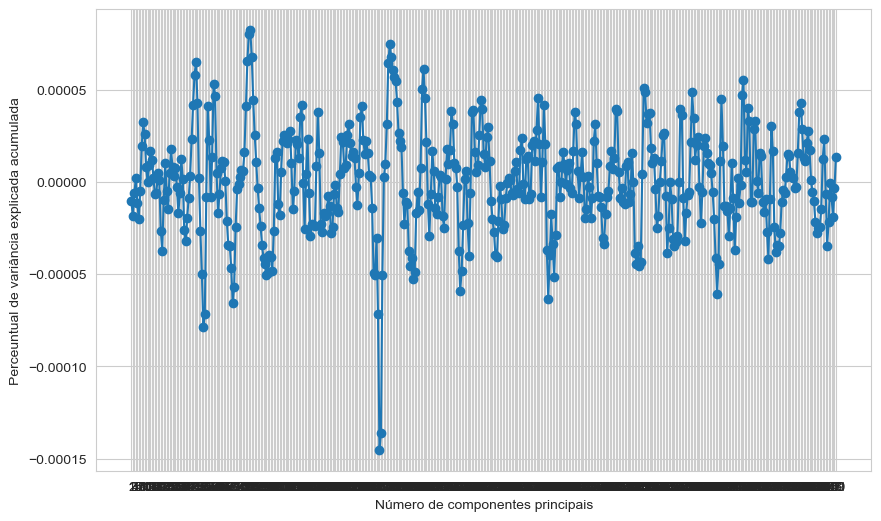

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
eixo_x = list(range(1, 482))
ax.plot(eixo_x, epochs_data_train[0][0], marker="o")
ax.set_xlabel("Número de componentes principais")
ax.set_ylabel("Perceuntual de variância explicada acumulada")
ax.set_xticks(eixo_x)
plt.show()

In [10]:
epochs_data_train.shape
# Number of events , channels, each measurement (f*t)

(4489, 64, 481)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(epochs_data_train, labels, test_size=0.3,shuffle = False, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2,shuffle = False, random_state=42)


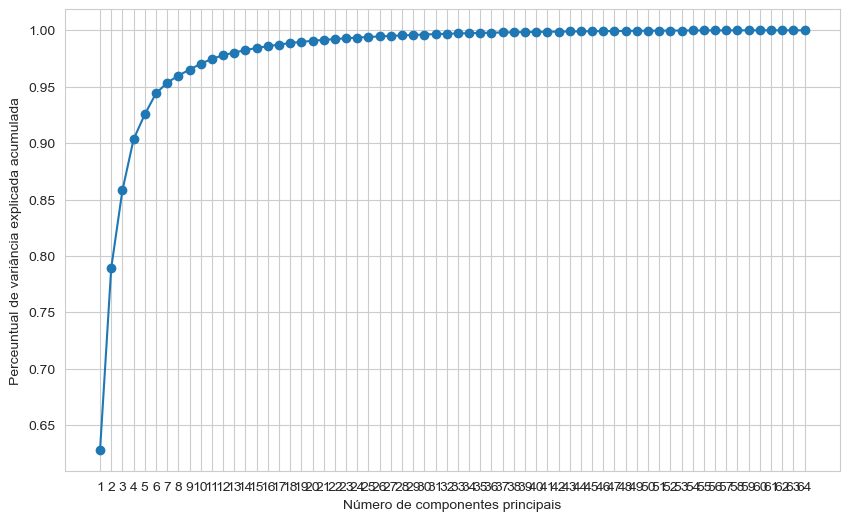

[0.627631 0.789262 0.858047 0.903368 0.925472 0.94401  0.953538 0.959789
 0.965163 0.97029  0.974701 0.977885 0.980324 0.982444 0.984361 0.9859
 0.987365 0.988701 0.989772 0.9907   0.991494 0.992246 0.992952 0.993555
 0.994088 0.994578 0.995042 0.995486 0.995886 0.996269 0.996625 0.996926
 0.997198 0.997445 0.997682 0.997905 0.998089 0.998261 0.998425 0.998584
 0.998729 0.998864 0.998989 0.999106 0.999217 0.999318 0.999412 0.999497
 0.999576 0.999649 0.999705 0.99976  0.999805 0.999845 0.999883 0.999911
 0.999933 0.999952 0.999964 0.999973 0.999981 0.999988 0.999994 1.      ] 0.9778846907903324


In [12]:
pca_channel = PCA()
for event in X_train:
    pca_channel.fit(event.T)

variancia_explicada_acumulada_channel = np.cumsum(pca_channel.explained_variance_ratio_)


fig, ax = plt.subplots(figsize=(10, 6))
eixo_x = list(range(1, len(variancia_explicada_acumulada_channel)+1))
ax.plot(eixo_x, variancia_explicada_acumulada_channel, marker="o")
ax.set_xlabel("Número de componentes principais")
ax.set_ylabel("Perceuntual de variância explicada acumulada")
ax.set_xticks(eixo_x)
plt.show()
print(variancia_explicada_acumulada_channel,variancia_explicada_acumulada_channel[12-1])

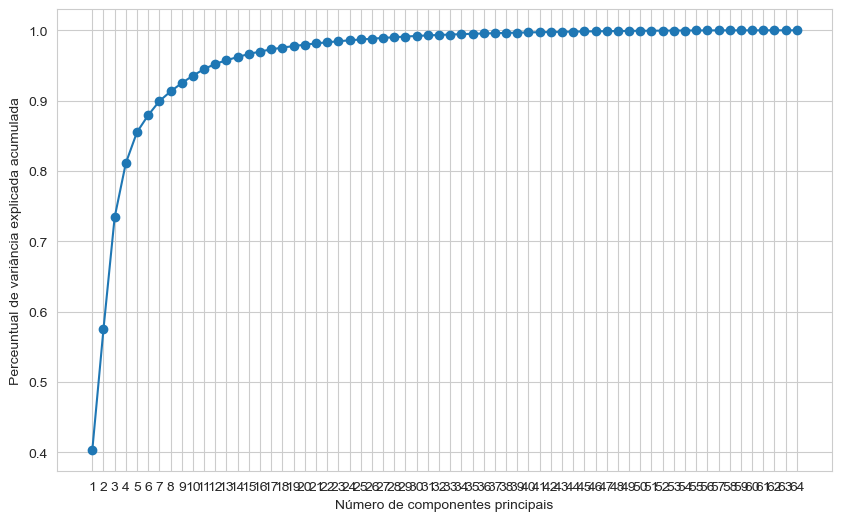

[0.40306  0.575212 0.734281 0.811269 0.855348 0.879381 0.899369 0.913101
 0.925009 0.935568 0.944895 0.952277 0.957487 0.962027 0.966362 0.969818
 0.972938 0.975425 0.977599 0.979526 0.981351 0.98301  0.984416 0.985788
 0.986973 0.988098 0.989175 0.9902   0.991114 0.991989 0.992758 0.993401
 0.993992 0.994547 0.995076 0.995503 0.995904 0.996285 0.996655 0.997011
 0.997336 0.997626 0.997897 0.998156 0.998395 0.998614 0.998816 0.998999
 0.999174 0.999304 0.999432 0.999537 0.999633 0.999724 0.999788 0.999843
 0.999887 0.999916 0.999936 0.999955 0.999972 0.999987 1.       1.      ] 0.9698179210161918


In [13]:
pca_data = PCA()
for event in X_train:
    pca_data.fit(event)

variancia_explicada_acumulada_data = np.cumsum(pca_data.explained_variance_ratio_)


fig, ax = plt.subplots(figsize=(10, 6))
eixo_x = list(range(1, len(variancia_explicada_acumulada_data)+1))
ax.plot(eixo_x, variancia_explicada_acumulada_data, marker="o")
ax.set_xlabel("Número de componentes principais")
ax.set_ylabel("Perceuntual de variância explicada acumulada")
ax.set_xticks(eixo_x)
plt.show()
print(variancia_explicada_acumulada_data,variancia_explicada_acumulada_data[16-1])

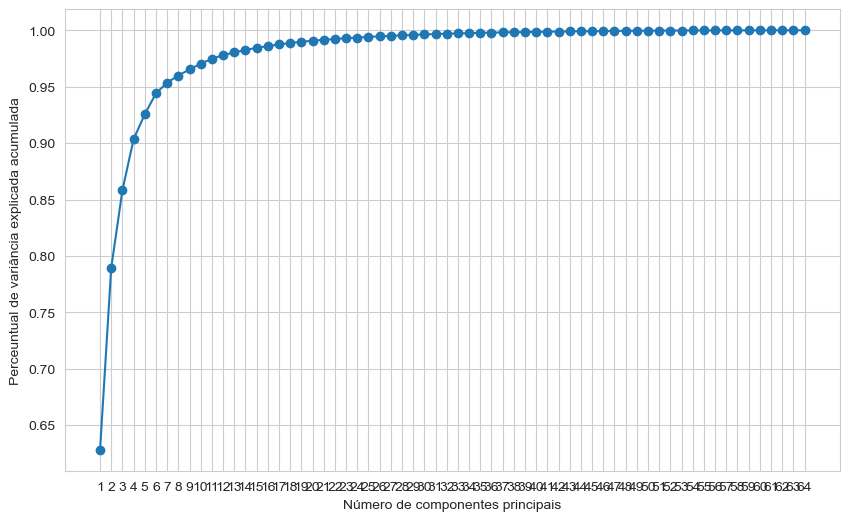

[0.627741 0.789391 0.858192 0.903488 0.925609 0.944113 0.953643 0.959907
 0.965304 0.970407 0.9748   0.97798  0.980421 0.982542 0.984454 0.985998
 0.987458 0.988785 0.989854 0.990781 0.991577 0.992328 0.993028 0.99363
 0.994163 0.994654 0.995118 0.995558 0.995959 0.996338 0.996687 0.996986
 0.997256 0.997504 0.997739 0.997957 0.998141 0.998313 0.998477 0.998633
 0.998777 0.99891  0.999034 0.99915  0.999258 0.999357 0.999449 0.999532
 0.999609 0.999675 0.999732 0.999782 0.999826 0.999865 0.999898 0.999923
 0.999944 0.99996  0.999971 0.99998  0.999987 0.999994 1.       1.      ] 0.9859984527119556


In [14]:
pca_channel_data = PCA()
for event in transform_channels_per_event("X_train",pca_channel):
    pca_channel_data.fit(event)

variancia_explicada_acumulada_channel_data = np.cumsum(pca_channel_data.explained_variance_ratio_)


fig, ax = plt.subplots(figsize=(10, 6))
eixo_x = list(range(1, len(variancia_explicada_acumulada_channel_data)+1))
ax.plot(eixo_x, variancia_explicada_acumulada_channel_data, marker="o")
ax.set_xlabel("Número de componentes principais")
ax.set_ylabel("Perceuntual de variância explicada acumulada")
ax.set_xticks(eixo_x)
plt.show()
print(variancia_explicada_acumulada_channel_data,variancia_explicada_acumulada_channel_data[16-1])

In [15]:
pca12_channel = PCA(n_components=12)
for event in X_train:
    pca12_channel.fit(event.T)

In [16]:
pca16_data = PCA(n_components=16)
for event in X_train:
    pca16_data.fit(event)

In [17]:
csp15 = mne.decoding.CSP(n_components=15, reg=None, log=True, norm_trace=False)
csp15.fit(X_train, y_train)


Computing rank from data with rank=None
    Using tolerance 0.0017 (2.2e-16 eps * 64 dim * 1.2e+11  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0017 (2.2e-16 eps * 64 dim * 1.2e+11  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 15,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [18]:

csp4 = mne.decoding.CSP(n_components=4, reg=None, log=True, norm_trace=False)
csp4.fit(X_train, y_train)

Computing rank from data with rank=None
    Using tolerance 0.0017 (2.2e-16 eps * 64 dim * 1.2e+11  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0017 (2.2e-16 eps * 64 dim * 1.2e+11  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 4,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [19]:
transform_list = []
for event in X_train:
    transform_list.append(pca12_channel.transform(event.T))
transform_list = np.stack(transform_list, axis=2) 

pca12_channel_csp4 = mne.decoding.CSP(n_components=4, reg=None, log=True, norm_trace=False)
pca12_channel_csp4.fit(transform_list.T, y_train)

Computing rank from data with rank=None
    Using tolerance 0.00032 (2.2e-16 eps * 12 dim * 1.2e+11  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00032 (2.2e-16 eps * 12 dim * 1.2e+11  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 4,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [20]:
transform_list = []
for event in X_train:
    transform_list.append(pca16_data.transform(event).T)
transform_list = np.stack(transform_list, axis=2) 

pca16_data_csp4 = mne.decoding.CSP(n_components=4, reg=None, log=True, norm_trace=False)
pca16_data_csp4.fit(transform_list.T, y_train)

Computing rank from data with rank=None
    Using tolerance 0.00092 (2.2e-16 eps * 64 dim * 6.5e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00092 (2.2e-16 eps * 64 dim * 6.5e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 4,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [91]:
# umap15_unsup = UMAP(n_components=15,random_state=42,n_neighbors=30,min_dist=0.05)
# umap15_unsup.fit(X_train[:,0,:])

c:\Users\Vinícius\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(min_dist=0.05, n_components=15, n_neighbors=30, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [ ]:
umap15 = UMAP(n_components=16,random_state=42,n_neighbors=30,min_dist=0.05)
for channel in range(64):
    umap15.fit(X_train[:,channel,:],y_train)

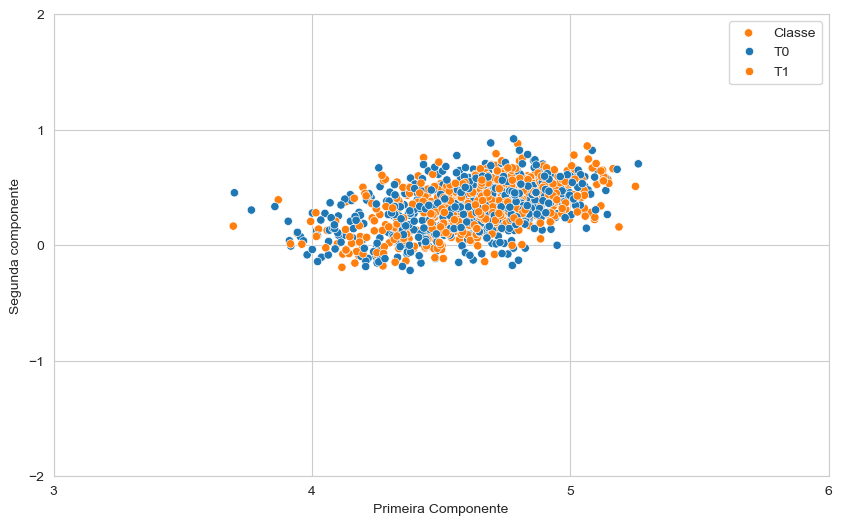

In [118]:
a = umap15.transform(X_val[:,0,:])
fig, ax = plt.subplots()
sns.scatterplot(ax = ax, x = a[:,0],y=  a[:,1], hue =  y_val,palette="tab10")
ax.set_ylabel("Segunda componente")
ax.set_xlabel("Primeira Componente")
ax.legend(["Classe","T0","T1","T2"])
ax.set_xticks(list(range(3, 6+1))) 
ax.set_yticks(list(range(-2, 2+1)))
plt.show()

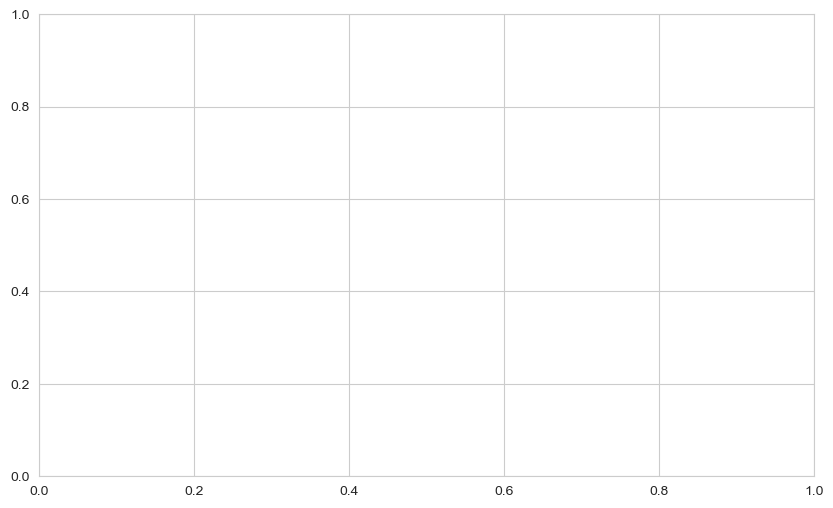

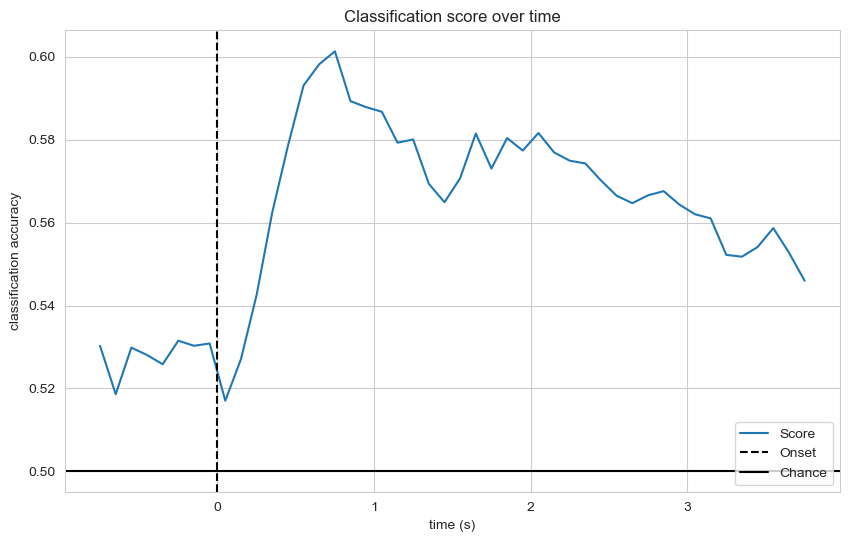

In [164]:
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)
sfreq = raw.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)
lda = LinearDiscriminantAnalysis()

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp4.transform(epochs_data_train[train_idx])

    # fit classifier
    lda.fit(X_train, y_train)

cv_split = cv.split(epochs_data_train)

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]
    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp4.transform(epochs_data[test_idx][:, :, n : (n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)


# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.title("Classification score over time")
plt.legend(loc="lower right")
plt.show()

In [35]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(transform_csp("X_train",csp4).shape[1],)),
    tf.keras.layers.Dropout(0.2),  # dropout layer
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dropout(0.2),  # dropout layer
    tf.keras.layers.Dense(1, activation='softmax')
])
optimizer = SGD(
    learning_rate=0.001
                # , momentum=0.2
                )
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [126]:
transform_data_points_per_event2("X_train",pca16_data).shape

(3142, 16, 64)

In [81]:
#Get Indices (it's the same for all, as suffle is False by default)
pipe = Pipe("lda_csp4",MLPClassifier(learning_rate_init= 0.0001,max_iter= 5000,hidden_layer_sizes= (100,20,5,1)),transform_channels_per_event("X_train",pca12_channel),np.concatenate)
pipeline = pipe.create_pipeline()
cv_results = cross_validate(pipeline, pipe.processed_X_train, y_train,return_train_score=True,return_estimator=True,return_indices=True, cv=10, scoring={'F1': 'f1_macro', 'Accuracy': make_scorer(accuracy_score)})

print(f"Results for pipeline with {pipe.name}:")
print("----------------")
print("Test accuracy scores:", cv_results['test_Accuracy'])
print("Mean test accuracy:", cv_results['test_Accuracy'].mean())
print("-----")
print("Test F1 scores:", cv_results['test_F1'])
print("Mean test F1:", cv_results['test_F1'].mean())
print("----------------")
print("train accuracy scores:", cv_results['train_Accuracy'])
print("Mean train accuracy:", cv_results['train_Accuracy'].mean())
print("-----")
print("train F1 scores:", cv_results['train_F1'])
print("Mean train F1:", cv_results['train_F1'].mean())
print("----------------")
print("Fit time:", cv_results['fit_time'])
print("Score time:", cv_results['score_time'])
print()
print("--------------------------------------------------------------------------------------------")

indices = cv_results["indices"]["test"]

Results for pipeline with lda_csp4:
----------------
Test accuracy scores: [0.55873  0.498413 0.487261 0.541401 0.547771 0.503185 0.5      0.525478
 0.503185 0.579618]
Mean test accuracy: 0.5245040946314832
-----
Test F1 scores: [0.546368 0.332627 0.353091 0.536588 0.546593 0.473969 0.333333 0.525242
 0.334746 0.575745]
Mean test F1: 0.45583031526077294
----------------
train accuracy scores: [0.515741 0.498762 0.504243 0.510962 0.516973 0.537482 0.498586 0.508133
 0.501061 0.537836]
Mean train accuracy: 0.5129778820016521
-----
train F1 scores: [0.51511  0.332783 0.466305 0.483241 0.51014  0.537454 0.332704 0.476902
 0.333804 0.537592]
Mean train F1: 0.452603526416645
----------------
Fit time: [0.731973 2.865999 1.589999 0.567022 1.024999 0.428001 0.988002 0.305996
 0.090003 0.847022]
Score time: [0.003003 0.003026 0.002998 0.002977 0.002001 0.002998 0.004    0.003025
 0.003    0.002977]

--------------------------------------------------------------------------------------------


In [57]:
lda_csp4 = Pipe("lda_csp4",LinearDiscriminantAnalysis(),transform_csp("X_train",csp4) )
lda_csp15 = Pipe("lda_csp15",LinearDiscriminantAnalysis(),transform_csp("X_train",csp15))
lda_pca12_channel_csp4 = Pipe("lda_pca12_channel_csp4",LinearDiscriminantAnalysis(),transform_channels_per_event_csp("X_train",pca12_channel,pca12_channel_csp4))
mnbc_csp4 = Pipe("mnbc_csp4",MultinomialNB(),transform_csp("X_train",csp4),np.abs)
mnbc_csp15 = Pipe("mnbc_csp15",MultinomialNB(),transform_csp("X_train",csp15),np.abs)
mnbc_pca12_channel_csp4 = Pipe("mnbc_pca12_channel_csp4",MultinomialNB(),transform_channels_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),np.abs)
MLP_csp4 = Pipe("MLP_csp4",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_csp("X_train",csp4))
Keras_MLP_csp4 = Pipe("Keras_MLP_csp4",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(10, activation='relu', input_shape=(transform_csp("X_train",csp4).shape[1],)),
            tf.keras.layers.Dense(5, activation='relu'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=100, batch_size=32, verbose=0,random_state=42),transform_csp("X_train",csp4))



Pipes = [
    lda_csp4,
    lda_csp15,
    
    
    
]


In [ ]:
results = []
for pipe in Pipes:
    print(pipe.name)
    # Create pipeline with the given pipe
    pipeline = pipe.create_pipeline()
    
    # Perform cross-validation
    cv_results = cross_validate(pipeline, pipe.processed_X_train, y_train,return_train_score=True,return_estimator=True, cv=10, scoring={'F1': 'f1_macro', 'Accuracy': make_scorer(accuracy_score)})

    print(f"Results for pipeline with {pipe.name}:")
    print("----------------")
    print("Test accuracy scores:", cv_results['test_Accuracy'])
    print("Mean test accuracy:", cv_results['test_Accuracy'].mean())
    print("-----")
    print("Test F1 scores:", cv_results['test_F1'])
    print("Mean test F1:", cv_results['test_F1'].mean())
    print("----------------")
    print("train accuracy scores:", cv_results['train_Accuracy'])
    print("Mean train accuracy:", cv_results['train_Accuracy'].mean())
    print("-----")
    print("train F1 scores:", cv_results['train_F1'])
    print("Mean train F1:", cv_results['train_F1'].mean())
    print("----------------")
    print("Fit time:", cv_results['fit_time'])
    print("Score time:", cv_results['score_time'])
    print()
    print("--------------------------------------------------------------------------------------------")

    results.append(cv_results)